In [1]:
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

2023-04-28 09:42:34.832656: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-28 09:42:34.861953: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-28 09:42:34.995908: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-28 09:42:34.996891: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-28 09:42:35.641749: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

Download:

- punkt
- stopwords
- averaged_perceptron_tagger

In [2]:
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------


True

# Funcion general

In [3]:
def plot_history(history, metric):
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training: {history.history["loss"][-1]:.2f}, validation: {history.history["val_loss"][-1]:.2f}')
    plt.legend()

    plt.subplot(1, 2, 2)
    #plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history[f'{metric}'], label='Training')
    plt.plot(history.history[f'val_{metric}'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Training: {history.history[f"{metric}"][-1]:.2f}, validation: {history.history[f"val_{metric}"][-1]:.2f}')
    plt.legend()

    plt.show()

# Apartir de aquí, la parte bonita del notebook. Diviertete!! ♥


Hecho por NeuralHive 🐝

In [4]:
papers_path = 'papers.csv'

In [5]:
df = pd.read_csv(papers_path)
print(df.shape)
df.head()

(4555, 3)


,title,abstract,keywords
0,Ensemble Statistical and Heuristic Models for ...,Statistical word alignment models need large a...,"['ensemble learning', 'word alignment']"
1,Improving Spectral Learning by Using Multiple ...,Spectral learning algorithms learn an unknown ...,"['basis selection', 'discrete fourier', 'ensem..."
2,Applying Swarm Ensemble Clustering Technique f...,Number of defects remaining in a system provid...,"['clustering', 'ensembles', 'particle swarm op..."
3,Reducing the Effects of Detrimental Instances,Not all instances in a data set are equally be...,"['filtering', 'instance weighting', 'label noi..."
4,Concept Drift Awareness in Twitter Streams,Learning in non-stationary environments is not...,"['adaptive', 'context', 'detection', 'time-fre..."


In [6]:
X = df["abstract"]
y = df["keywords"]

# Abstracts

## Data exploration && cleanning

Data exploration and cleaning of all abstracts.

1. Data exploration
    1. Repetition of words
    2. Frecuency of words
    3. Length of words
    4. Get hapaxes

Collect all the abstracts into one. This way, we are going to have a top view of the dataset.

In [7]:
mono_abstract = ''

for abstract in X.values:
    mono_abstract += abstract

mono_abstract = mono_abstract.lower()
len(mono_abstract)

5105857

First tokenize. This means separating into words the string.

In [8]:
mono_token = nltk.word_tokenize(mono_abstract)
mono_token[:5]

['statistical', 'word', 'alignment', 'models', 'need']

As we can appreciate, the collocations from using `collocations()` from Text are way better from `BigramCollocationFinder`.

In [9]:
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder

In [10]:
finder = BigramCollocationFinder.from_words(nltk.bigrams(mono_token))

# specify a measure for identifying collocations
measures = BigramAssocMeasures()

# get the 10 most frequent collocations using the specified measure
collocations = finder.nbest(measures.raw_freq, 10)

In [11]:
collocations

[(('.', 'in'), ('in', 'this')),
 (('in', 'this'), ('this', 'paper')),
 (('this', 'paper'), ('paper', ',')),
 (('paper', ','), (',', 'we')),
 (('.', 'however'), ('however', ',')),
 (('.', 'this'), ('this', 'paper')),
 ((',', 'we'), ('we', 'propose')),
 (('in', 'order'), ('order', 'to')),
 (('as', 'well'), ('well', 'as')),
 (('we', 'propose'), ('propose', 'a'))]

Convert those tokens into a Text object. The best way to get collocations out of it. These collocations are of 2 words or also called (Bigrams)

In [12]:
import io
import contextlib

In [13]:
mono_abstract = nltk.Text(mono_token)

In [14]:
with contextlib.redirect_stdout(io.StringIO()) as f:
    mono_abstract.collocations()

collocations_output = f.getvalue()
print(collocations_output) # top 10 collocations

machine learning; neural network; neural networks; experimental
results; results show; deep learning; support vector; time series;
convolutional neural; feature selection; future research; paper
presents; reinforcement learning; comprehensive survey; recent years;
proposed method; research directions; deep neural; anomaly detection;
data sets



#### Repetitions

In [15]:
fdist1 = nltk.punkt.FreqDist(mono_token)
top_tokens = fdist1.most_common(10)
token_counts = dict(top_tokens)
top_tokens[:10]

[('the', 42923),
 (',', 34425),
 ('.', 28657),
 ('of', 27638),
 ('and', 23294),
 ('to', 19254),
 ('a', 16768),
 ('in', 16275),
 ('is', 9338),
 ('for', 9212)]

<AxesSubplot:>

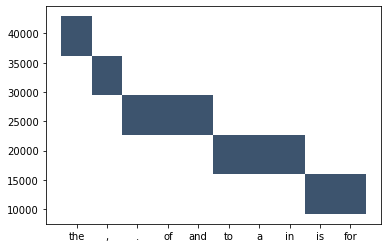

In [16]:
sns.histplot(x=list(token_counts.keys()), y=list(token_counts.values()))

In [17]:
hapaxes = fdist1.hapaxes()

#### Frequency

Como podemos observar, mono_token está compuesto de casi un millon de palabras. De las cuales, aproximadamente el 27% no son totalmente útiles. Como se puede observar, las palabras como `the`, `,`, `.`, `a`, `in`. Are very common and for the purpose of this project, they are not necessary and thus generate noise on model that tries to extract characteristics.

In [18]:
len(mono_token)

826346

In [19]:
freq = 0.0
for word, _ in top_tokens:
    freq += fdist1.freq(word)
    print(f'- {word} : {fdist1.freq(word)}')

print(f'Frequency of top 10 words repeated {freq}.')

- the : 0.05194313277973149
- , : 0.041659304940061426
- . : 0.034679177971455054
- of : 0.033446038342292456
- and : 0.02818916047273176
- to : 0.02330016724229318
- a : 0.020291742199998547
- in : 0.019695139808264334
- is : 0.01130035118461274
- for : 0.011147872682871339
Frequency of top 10 words repeated 0.2756520876243123.


#### Length of words

Al parecer las palabras más repetidas son las de tamaño 2. Suponiendo un 14% de todos los abstracts. Lo cual parece muy interesante ya que, si juntamos el apartado anterior con este, podremos observar que palabras de 2 solo se muestran 4.

Esta parte del razonamiento se mirará más tarde cuando se clasifiquen las palabras

In [20]:
fdLen = nltk.punkt.FreqDist(len(w) for w in mono_token)

In [21]:
max = fdLen.max()
print(f'El tamaño de las palabras más repetidas es {max}:\n\t- Frecuencia : {fdLen[max]}\n\t- Frecuencia (%): {fdLen.freq(max)}')

El tamaño de las palabras más repetidas es 2:
	- Frecuencia : 115879
	- Frecuencia (%): 0.1402306055816813


#### Hapaxes

There are 12893 hapaxes, that is around 1% (0.0156) of all the abstracts. So we are going to eliminate them.

In [22]:
print(f'Nº de palabras únicas: {len(fdist1.hapaxes())}, ejemplos: {fdist1.hapaxes()[:5]}')

Nº de palabras únicas: 12893, ejemplos: ['models.spectral', 'practice.number', 'models.not', 'them.learning', 'timestamping']


#### (Exploration) Remove non-alphanumeric characters from the list of words

Como se puede observar, esto es una gran hostia, porque podemos ver que son 109645 (13%) de las palabras. Esto es bueno porque para nuestro clasificador, no nos intersa que existan simbolos de puntuación. La diferencia entre `No, eso es bueno` y `No es bueno`. No está dentro de nuestro scope.

In [23]:
only_alpha = len([word for word in mono_token if word.isalpha()])
only_alpha

716701

In [24]:
len(mono_token) - only_alpha

109645

#### (Exploration) Remove articles

To do this task, first we need to classify the tokenized words, and use a pretrained model from `nltk`. For this we have to download the package: `averaged_perceptron_tagger`.

- `cc` coordinating conjunction
- `rb` adverbs
- `in` preposition
- `nn` noun
- `jj` adjective
- `vbp` verb

In [25]:
tags = nltk.pos_tag(mono_token)
tags[:5]

[('statistical', 'JJ'),
 ('word', 'NN'),
 ('alignment', 'NN'),
 ('models', 'NNS'),
 ('need', 'VBP')]

In [26]:
# get rid of prepositions
with_no_prepositions = len([word for word, tag in tags if tag != 'IN'])
with_no_prepositions

733956

In [27]:
len(mono_token) - with_no_prepositions

92390

Como se ha podido observar, nos interesa quitar tanto las preopisiciones como los valores que no son alphanuméricos. A continuación, para terminar, se analizará de nuevo, las repeticiones de los top 10 y el tamaño de palabras más grande.

#### Conclusión

Como se ha podido observar, nos interesa quitar tanto las preopisiciones como los valores que no son alphanuméricos. A continuación, para terminar, se analizará de nuevo, las repeticiones de los top 10 y el tamaño de palabras más grande.

In [28]:
# remove hapaxes from the frequency distribution
fdist2 = nltk.punkt.FreqDist(mono_token)
for hapax in fdist2.hapaxes():
    del fdist2[hapax]

In [29]:
print(f'fdist2 (get rid of hepaxes): {len(fdist2)} - fdist1: {len(fdist1)}')

fdist2 (get rid of hepaxes): 15667 - fdist1: 28560


In [30]:
new_X = fdist2.keys()

In [31]:
only_alpha = [word for word in new_X if word.isalpha()]

In [32]:
len(only_alpha)

12415

In [33]:
new_X = only_alpha
tags = nltk.pos_tag(new_X)

In [34]:
with_no_prepositions = [word for word, tag in tags if tag != 'IN']

In [35]:
new_X = with_no_prepositions
fdLen_2 = nltk.punkt.FreqDist(len(w) for w in with_no_prepositions)
max = fdLen_2.max()
print(f'El tamaño de las palabras más repetidas es {max}:\n\t- Frecuencia : {fdLen_2[max]}\n\t- Frecuencia (%): {fdLen_2.freq(max)}')

El tamaño de las palabras más repetidas es 8:
	- Frecuencia : 1505
	- Frecuencia (%): 0.12237762237762238


In [36]:
for w in new_X:
    if len(w) == max:
        print(f'Example of most repetitive len ({max}) : {w}')
        break

Example of most repetitive len (8) : training


Como se puede ver, la diferencia entre quitar o no las palabras con 2 caracteres. Al parecer y como intuímos anteriormente, la gran mayoría eran preposiciones y otros caracteres de la categoría `IN`

In [37]:
print(f'Sizes of each step:\n\t- hapaxes removed : {len(fdist2)}\n\t- Only alpha numerics: {len(only_alpha)}\n\t- Prepositions removed: {len(with_no_prepositions)}\n\nSize of new X is: {len(new_X)}')

Sizes of each step:
	- hapaxes removed : 15667
	- Only alpha numerics: 12415
	- Prepositions removed: 12298

Size of new X is: 12298


Bueno, igual 12k no es lo mejor del mundo, pero como todo en esta vida, hay que probarlo. Eso es lo que vamos a hacer!!

## Cleanning

1. Cleanning
    1. Remove '.', ',', '?', etc.
    2. Remove hepaxes if they are not specific (or niche).
    3. Remove (if needed) words with low frequency


This cleaning is for each of the abstracts and not as a molotic abstract thing, like earlier.

In [38]:
token_list = []

for abstract in X.values:
    token_list.append(nltk.word_tokenize(abstract.lower()))

print(f'Size of token_list : {len(token_list)} (must be 4555 same size as X)')
print(f'Example of abstract 0 (len): {len(token_list[0])}. First 5 words: {token_list[0][:5]}')

Size of token_list : 4555 (must be 4555 same size as X)
Example of abstract 0 (len): 119. First 5 words: ['statistical', 'word', 'alignment', 'models', 'need']


In [39]:
# Get overall hapaxes
fdist2 = nltk.punkt.FreqDist(mono_token)
global_hapaxes = fdist2.hapaxes()
global_hapaxes[:5]

['models.spectral',
 'practice.number',
 'models.not',
 'them.learning',
 'timestamping']

In [40]:
hapax_dict = {i: None for i in global_hapaxes}

In [41]:
[word for word in token_list[0] if word not in hapax_dict]

['statistical',
 'word',
 'alignment',
 'models',
 'need',
 'large',
 'amount',
 'of',
 'training',
 'data',
 'while',
 'they',
 'are',
 'weak',
 'in',
 'small-size',
 'corpora',
 '.',
 'this',
 'paper',
 'proposes',
 'a',
 'new',
 'approach',
 'of',
 'unsupervised',
 'hybrid',
 'word',
 'alignment',
 'technique',
 'using',
 'ensemble',
 'learning',
 'method',
 '.',
 'this',
 'algorithm',
 'uses',
 'three',
 'base',
 'alignment',
 'models',
 'in',
 'several',
 'rounds',
 'to',
 'generate',
 'alignments',
 '.',
 'the',
 'ensemble',
 'algorithm',
 'uses',
 'a',
 'weighed',
 'scheme',
 'for',
 'resampling',
 'training',
 'data',
 'and',
 'a',
 'voting',
 'score',
 'to',
 'consider',
 'aggregated',
 'alignments',
 '.',
 'the',
 'underlying',
 'alignment',
 'algorithms',
 'used',
 'in',
 'this',
 'study',
 'include',
 'ibm',
 'model',
 '1',
 ',',
 '2',
 'and',
 'a',
 'heuristic',
 'method',
 'based',
 'on',
 'dice',
 'measurement',
 '.',
 'our',
 'experimental',
 'results',
 'show',
 'that'

In [42]:
clean_abstracts = []
for abs_tok in token_list:
    # remove hapaxes from the frequency distribution
    # Only hapaxes from the overall
    abs_freq = [word for word in abs_tok if word not in hapax_dict]

    # remove non-alphanumeric values
    only_alpha = [word for word in abs_freq if word.isalpha()]

    # remove `IN`
    tags = nltk.pos_tag(only_alpha)
    with_no_prepositions = [word for word, tag in tags if tag != 'IN']

    clean_abstracts.append(' '.join(with_no_prepositions))

del token_list

print(f'Size of clean_abstracts : {len(clean_abstracts)} (must be 4555 same size as X)')
print(f'Example length of new abstract: {len(clean_abstracts[0])}. First 5 words: {clean_abstracts[0][:5]}')

Size of clean_abstracts : 4555 (must be 4555 same size as X)
Example length of new abstract: 642. First 5 words: stati


In [43]:
clean_abstracts[0]

'statistical word alignment models need large amount training data they are weak corpora this paper proposes a new approach unsupervised hybrid word alignment technique using ensemble learning method this algorithm uses three base alignment models several rounds to generate alignments the ensemble algorithm uses a weighed scheme resampling training data and a voting score to consider aggregated alignments the underlying alignment algorithms used this study include ibm model and a heuristic method based dice measurement our experimental results show this approach the alignment error rate could be improved least the base alignment models'

In [44]:
## TODO: CHECK THIS

In [45]:
# create a list of string lengths
lengths = [len(s) for s in clean_abstracts]

# sort the list of lengths
lengths_sorted = sorted(lengths)

# find the middle index of the sorted list
middle_index = len(lengths_sorted) // 2


if len(lengths_sorted) % 2 == 1:
    # if odd, the median is the value at the middle index
    median = lengths_sorted[middle_index]
else:
    # if even, the median is the average of the values at the middle two indices
    median = (lengths_sorted[middle_index - 1] + lengths_sorted[middle_index]) / 2

print(f'The median is: {median}')

The median is: 925


# Keywords

## Data exploration

Data exploration and cleaning of all abstracts.

1. Data exploration
    1. Repetitions of keywords
    2. Evaluation of different percentiles
    3. Frequency of keywords together in the same row

### Repetition of keywords

Before getting the bars. We need to parse the keywords from a string to a list of strings.

In [46]:
words = []

for i, abs in enumerate(y.values):
    words.append([])
    for w in abs.replace('[', '').replace(']', '').replace('\'', '').split(','):
        words[i].append(w.strip())

flat_keys = [item for subkeys in words for item in subkeys]

print("Terminado, hay", len(flat_keys), "palabras")

Terminado, hay 31607 palabras


As we can appreciate, the most common one is `machine learning` by far. From there, we can see that each key is followed closely.

('interference constraints', 1)


Text(0, 0.5, 'Key')

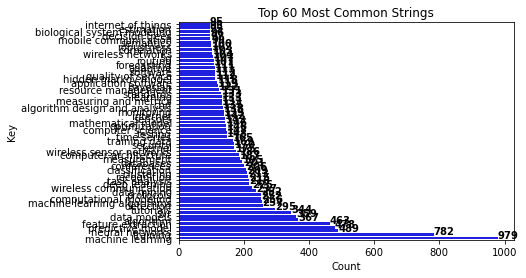

In [47]:
from collections import Counter

string_counts = Counter(flat_keys)
print(string_counts.most_common()[-1])
top_strings = string_counts.most_common(60)

df = pd.DataFrame(top_strings, columns=['Key', 'Count'])
df = df.iloc[::-1]  # Reverse the order of rows
labels, counts = zip(*top_strings)

fig, ax = plt.subplots()
sns.barplot(x='Count', y='Key', data=df, color='blue')

# Add count label for each bar
for i, v in enumerate(counts[::-1]):
    ax.text(v + 0.5, i, str(v), color='black', fontweight='bold')

ax.set_title("Top 60 Most Common Strings")
ax.set_xlabel("Count")
ax.set_ylabel("Key")

### Evaluation of different percentiles

I don't know exactly the percentiles they are. But we can infere the definition of percentile for this use case.

It can be very obvious that we should use under 50 as a minimum. Think about this, we cannot use as minimum under 3 repetitions since, 6% is repeated, compared to the 10% of the 50. As you can see, the probability of finding a keyword with repetition X is not accumulative (on this example). But it can be done.

In [48]:
una_sola_vez = 0
poco_frecuentes = 0
poco_frecuentes_50 = 0
poco_frecuentes_90 = 0
poco_frecuentes_100 = 0

# dejamos la elegancia de lado
for i in string_counts:
  if string_counts.get(i) < 3:
    poco_frecuentes +=1

for i in string_counts:
  if string_counts.get(i) < 2:
    una_sola_vez +=1

for i in string_counts:
  if string_counts.get(i) < 50:
    poco_frecuentes_50 +=1

for i in string_counts:
  if string_counts.get(i) < 90:
    poco_frecuentes_90 +=1

for i in string_counts:
  if string_counts.get(i) < 100:
    poco_frecuentes_100 +=1

print("De las", len(flat_keys), "palabras totales hay", poco_frecuentes, "palabras que aparecen menos de 3 veces, de las cuales", una_sola_vez, "aparecen una sola vez.")
print("Es decir, un", (una_sola_vez/len(flat_keys))*100,"% de las palabras aparecen una sola vez")
print("Es decir, un", (poco_frecuentes/len(flat_keys))*100,"% de las palabras aparecen tres veces")
print("Es decir, un", (poco_frecuentes_50/len(flat_keys))*100,"% de las palabras aparecen 50 veces")
print("Es decir, un", (poco_frecuentes_90/len(flat_keys))*100,"% de las palabras aparecen 90 veces")
print("Es decir, un", (poco_frecuentes_100/len(flat_keys))*100,"% de las palabras aparecen 100 veces")

De las 31607 palabras totales hay 2109 palabras que aparecen menos de 3 veces, de las cuales 1626 aparecen una sola vez.
Es decir, un 5.144430031322175 % de las palabras aparecen una sola vez
Es decir, un 6.672572531401272 % de las palabras aparecen tres veces
Es decir, un 10.510329990192046 % de las palabras aparecen 50 veces
Es decir, un 10.706489068877149 % de las palabras aparecen 90 veces
Es decir, un 10.73812762995539 % de las palabras aparecen 100 veces


### Get new keys under X

In [49]:
flat_keys[0]

'ensemble learning'

In [50]:
arr = np.array(flat_keys)

# contar ocurrencias de todas las palabras
unique_vals, val_counts = np.unique(arr, return_counts=True)

# filtrar los valores con más de 2 o 3 repeticiones
filtered_vals_under2 = unique_vals[val_counts >= 2]         # las leyes de DeMorgan lo convierten en < 2, eliminando los que aparecen una sola vez
filtered_vals_under3 = unique_vals[val_counts >= 3]         # las leyes de DeMorgan lo convierten en < 3, eliminando los que aparecen dos veces o menos
filtered_vals_under50 = unique_vals[val_counts >= 50]         # las leyes de DeMorgan lo convierten en < 50, eliminando los que aparecen dos veces o menos
filtered_vals_under90 = unique_vals[val_counts >= 90]         # las leyes de DeMorgan lo convierten en < 90, eliminando los que aparecen dos veces o menos
filtered_vals_under100 = unique_vals[val_counts >= 100]         # las leyes de DeMorgan lo convierten en < 100, eliminando los que aparecen dos veces o menos

# obtenemos al quitar 
filtered_arr_under2 = arr[np.isin(arr, filtered_vals_under2)]       # quitamos los que aparecen una sola vez
filtered_arr_under3 = arr[np.isin(arr, filtered_vals_under3)]       # quitamos los que aparecen dos veces o menos
filtered_arr_under50 = arr[np.isin(arr, filtered_vals_under50)]       # quitamos los que aparecen 50 veces o menos
filtered_arr_under90 = arr[np.isin(arr, filtered_vals_under90)]       # quitamos los que aparecen 50 veces o menos
filtered_arr_under100 = arr[np.isin(arr, filtered_vals_under100)]       # quitamos los que aparecen 50 veces o menos

print("Tal y como vimos antes,", len(flat_keys)-len(filtered_arr_under2), "palabras que aparecen una vez y", len(flat_keys)-len(filtered_arr_under3), "palabras que aparecen dos veces o menos")
print("Lo cual nos deja con", len(filtered_arr_under2), "palabras si quitamos las que aparecen una vez y", len(filtered_arr_under3), "si quitamos las que aparecen dos veces o menos")

print(f"Quitar las repeticiones menores de 50, nos deja con {len(np.unique(filtered_arr_under50))} keywords unicas.")
print(f"Quitar las repeticiones menores de 90, nos deja con {len(np.unique(filtered_arr_under90))} keywords unicas.")
print(f"Quitar las repeticiones menores de 100, nos deja con {len(np.unique(filtered_arr_under100))} keywords unicas.")

Tal y como vimos antes, 1626 palabras que aparecen una vez y 2592 palabras que aparecen dos veces o menos
Lo cual nos deja con 29981 palabras si quitamos las que aparecen una vez y 29015 si quitamos las que aparecen dos veces o menos
Quitar las repeticiones menores de 50, nos deja con 126 keywords unicas.
Quitar las repeticiones menores de 90, nos deja con 64 keywords unicas.
Quitar las repeticiones menores de 100, nos deja con 54 keywords unicas.


### Frequency of keywords together in the same row

Now we are going to obtain more information about the sesgation and unbalance of the keywords. It is of our interest to relationate each words. For this, we are going to use a correlation matrix.

> `underX` is intended to have the `X` so that you don't have to change the code 100 times

_**CHANGE THIS VALUE TO 2, 3, 50, 90 or 100**_

In [51]:
underX = pd.DataFrame(filtered_arr_under100, columns=['Keywords'])

Las palabras más frecuentes, como podemos ver, aparecen juntas con una frecuencia muy baja, lo que da a entender que en los datos está presente una gran cantidad de ruido.

/tmp/ipykernel_386/106516927.py:3: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  keyw = pd.get_dummies(underX['Keywords'].apply(pd.Series).stack()).sum(level=0)


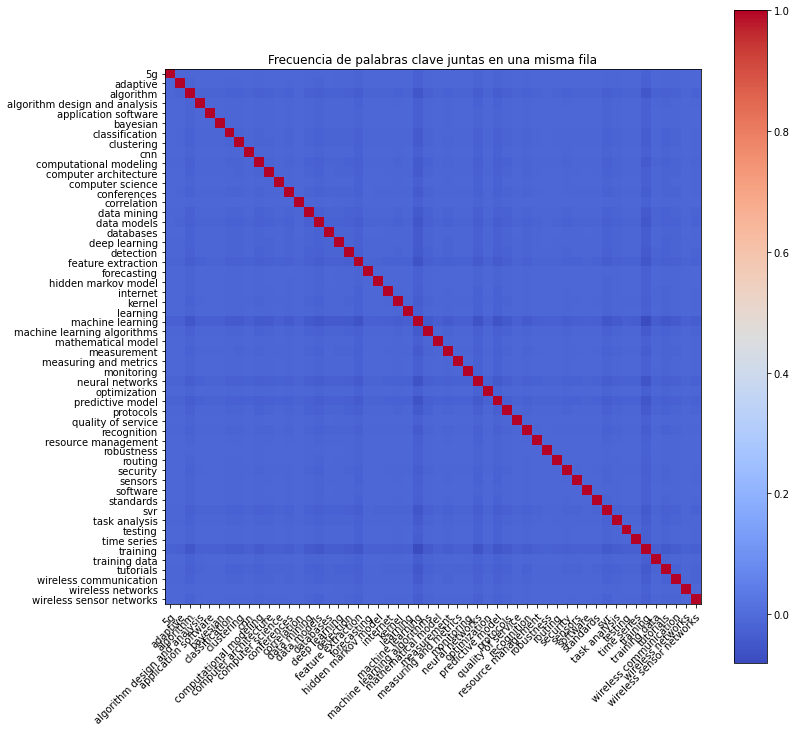

In [52]:
# Convertimos las palabras en valores numéricos
keyw = pd.DataFrame(words)
keyw = pd.get_dummies(underX['Keywords'].apply(pd.Series).stack()).sum(level=0)

# crea la matriz de correlación
corr_matrix = np.corrcoef(keyw, rowvar=False)

# crea el mapa de calor con matplotlib
fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(corr_matrix, cmap='coolwarm')

# personaliza los ejes y el título del mapa de calor
ax.set_xticks(np.arange(len(keyw.columns)))
ax.set_yticks(np.arange(len(keyw.columns)))
ax.set_xticklabels(keyw.columns)
ax.set_yticklabels(keyw.columns)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_title("Frecuencia de palabras clave juntas en una misma fila")

# añade una barra de color al mapa de calor
cbar = ax.figure.colorbar(im, ax=ax)

# muestra el mapa de calor
plt.show()

In [53]:
len(np.unique(underX))

54

In [54]:
np.unique(underX)

array(['5g', 'adaptive', 'algorithm', 'algorithm design and analysis',
       'application software', 'bayesian', 'classification', 'clustering',
       'cnn', 'computational modeling', 'computer architecture',
       'computer science', 'conferences', 'correlation', 'data mining',
       'data models', 'databases', 'deep learning', 'detection',
       'feature extraction', 'forecasting', 'hidden markov model',
       'internet', 'kernel', 'learning', 'machine learning',
       'machine learning algorithms', 'mathematical model', 'measurement',
       'measuring and metrics', 'monitoring', 'neural networks',
       'optimization', 'predictive model', 'protocols',
       'quality of service', 'recognition', 'resource management',
       'robustness', 'routing', 'security', 'sensors', 'software',
       'standards', 'svr', 'task analysis', 'testing', 'time series',
       'training', 'training data', 'tutorials', 'wireless communication',
       'wireless networks', 'wireless sensor netw

## Cleanning

1. Cleanning
    1. Remove words which are similar. (Here for the future, we could use nltk `similarity()`)


This cleaning is for each of the abstracts and not as a molotic abstract thing, like earlier.

Al tratarse de únicamente 54 valores, vamos a intentar agrupar a mano para reducir algo el ruido las palabras clave que estén relacionadas.

In [55]:
underX = pd.get_dummies(underX['Keywords'].apply(pd.Series).stack()).sum(level=0)

/tmp/ipykernel_386/2748233728.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  underX = pd.get_dummies(underX['Keywords'].apply(pd.Series).stack()).sum(level=0)


Creamos un multi-hot, para agrupar a posteriori

In [56]:
# Agrupamiento de las keywords que tienen que ver con redes inalámbricas en una sola "wireless"
underX["wireless"] = underX["5g"] + underX["wireless networks"] + underX["wireless sensor networks"] + underX["wireless communication"]
keywords_clean = underX.drop(["5g", "wireless sensor networks", "wireless communication"], axis=1)

# Agrupamiento de palabras clave de algoritmos
underX["algorithms"] = underX["algorithm"] + underX["algorithm design and analysis"] + underX["wireless sensor networks"] + underX["machine learning algorithms"]
keywords_clean = underX.drop(["algorithm", "algorithm design and analysis", "machine learning algorithms"], axis=1)

# Agrupamiento de palabras clave de minería de datos
underX["mining"] = underX["classification"] + underX["clustering"] + underX["data mining"] + underX["correlation"]
keywords_clean = underX.drop(["classification", "clustering", "data mining", "correlation"], axis=1)

# Agrupamiento de palabras clave de computers
underX["computers"] = underX["computational modeling"] + underX["computer architecture"] + underX["computer science"]
keywords_clean = underX.drop(["computational modeling", "computer architecture", "computer science"], axis=1)

In [57]:
underX.head()

,5g,adaptive,algorithm,algorithm design and analysis,application software,bayesian,classification,clustering,cnn,computational modeling,...,training,training data,tutorials,wireless communication,wireless networks,wireless sensor networks,wireless,algorithms,mining,computers
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
def join_keywords(row):
    keywords_list = []
    for column in row.index:
        if row[column] == 1:
            keywords_list.append(column)
    return keywords_list

In [59]:
data = []
words_df_underX = pd.DataFrame(data, columns=['keywords'])

In [60]:
words_df_underX['keywords'] = underX.apply(join_keywords, axis=1)
words_df_underX

,keywords
0,"[clustering, mining]"
1,[software]
2,[adaptive]
3,[detection]
4,[recognition]
...,...
11779,[application software]
11780,"[computer science, computers]"
11781,[machine learning]
11782,[neural networks]


# Preprocessing

1. Tokenize keywords
2. Join keywords wih abstracts
3. Get rid of rows with no keywords after purge
4. Tokenize abstracts

Ideas for future:
- With `occurrences` we can do https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras

In [61]:
# Constants
EMBEDDING_DIM = 300

MAX_VOCAB_SIZE = 40000

# tamaño de la frase más larga con la que alimentar el modelo
# se escoge la mediana para evitar anomalías
MAX_SEQUENCE_LENGTH = median

### Define tokenizer function && multihot

This tokenizer function is for this special purpose.
The multi-hot is used to generate the `y`

In [62]:
def tokenize_and_add_padding(words, tokenizer, max_sequence_length=None):
    tokenizer.fit_on_texts(words)
    sequences = tokenizer.texts_to_sequences(words)
    word_index = tokenizer.word_index
    data = None
    
    if max_sequence_length is not None:
        data = tf.keras.preprocessing.sequence.pad_sequences(
            sequences,
            maxlen=max_sequence_length
        )
        print('Shape of data tensor:', data.shape)

    print('Found %s unique tokens.' % len(word_index))

    return sequences, word_index, data

In [63]:
def multihot_tokenize(target, y_sequences, word_index):
    output_size = len(word_index.keys())
    multi_hot_tokenized = []

    for i, keys in enumerate(target):
        multi_hot_tokenized.append(np.zeros(output_size+1))
        for key in keys:
            if key in word_index:
                multi_hot_tokenized[i][word_index[key]] = 1

    multi_hot_tokenized = np.asarray(multi_hot_tokenized)
    multi_hot_tokenized[0]

    return multi_hot_tokenized

### Create tokenizer

In [64]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_VOCAB_SIZE)

### Tokenize keywords

Remember to choose the same frecuency or percentile done earlier.

> Remember the `X`

In [65]:
targets_under_X = []
filtered_arr_under100_dict = {i: None for i in filtered_arr_under100}

for i, keys in enumerate(words):
    targets_under_X.append([])
    for key in keys:
        if key in filtered_arr_under100_dict:
            targets_under_X[i].append(key)

In [66]:
y_sequencesX, y_word_indexX, _ = tokenize_and_add_padding(targets_under_X, tokenizer)
OUTPUT_SIZE_UNDER_X = len(y_word_indexX.keys())
OUTPUT_SIZE_UNDER_X

Found 54 unique tokens.


54

In [67]:
len(y_sequencesX)

4555

### Get rid of rows with no keywords after purge


In [68]:
len(clean_abstracts) == len(y_sequencesX)

True

In [69]:
# Create new dataframe with newly abstracts
prepro = pd.DataFrame(clean_abstracts, columns=['Abstracts'])
prepro['keywords'] = y_sequencesX
prepro.head()

,Abstracts,keywords
0,statistical word alignment models need large a...,[]
1,spectral learning algorithms learn an unknown ...,[]
2,number defects remaining a system provides an ...,"[19, 47]"
3,not all instances a data set are equally benef...,[]
4,learning environments is not an easy task and ...,"[48, 10]"


Now eliminate abstracts with empty list as keywords

In [70]:
df_under_X = prepro[prepro['keywords'].apply(len) > 0]
df_under_X.head()

,Abstracts,keywords
2,number defects remaining a system provides an ...,"[19, 47]"
4,learning environments is not an easy task and ...,"[48, 10]"
6,captchas are tests that are widely used the in...,[18]
7,reinforcement learning techniques become more ...,"[1, 27]"
8,signatures are the single most widely used met...,"[20, 2]"


In [71]:
abstracts = df_under_X['Abstracts'].values[:]

abstracts.shape

(4186,)

### Tokenize abstracts

In [72]:
sequences, word_index, data = tokenize_and_add_padding(abstracts, tokenizer, MAX_SEQUENCE_LENGTH)

Shape of data tensor: (4186, 925)
Found 12352 unique tokens.


### Create multihot

In [73]:
targets_under_X_flatten = [lst for lst in targets_under_X if lst]
multihot_X = multihot_tokenize(targets_under_X_flatten, y_sequencesX, y_word_indexX)
multihot_X.shape

(4186, 55)

## Train GLoVe

Vamos a entrenar una capa de word embedding con el conjunto de datos de Stanford:

In [74]:
import os
import requests
from shutil import unpack_archive

In [75]:
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (16, 9),'figure.dpi': 100})

tf.compat.v1.disable_eager_execution()  # Esto es por un problema (creo) con las RTX2070

In [76]:
GLOVE_URL = 'http://nlp.stanford.edu/data/glove.6B.zip'
GLOVE_FILE = 'glove.6B.zip'
GLOVE_DIR = 'glove'

if not os.path.isdir(GLOVE_DIR):
    # Descargamos el dataset comprimido de GloVe (si no lo tenemos ya)
    if not os.path.exists(GLOVE_FILE):
        with open(GLOVE_FILE, 'wb') as f:
            r = requests.get(GLOVE_URL, allow_redirects=True)
            f.write(r.content)
    # Lo descomprimimos en el directorio 'glove'
    unpack_archive(GLOVE_FILE, 'glove/')

We load the Embedding of the dimension specified in the configuration

In [77]:
print(f'Loading GloVe {EMBEDDING_DIM}-d embedding... ', end='')
word2vec = {}
with open(os.path.join(GLOVE_DIR, f'glove.6B.{EMBEDDING_DIM}d.txt')) as f:
    for line in f:
        values = line.split()
        word2vec[values[0]] = np.asarray(values[1:], dtype='float32')
print(f'done ({len(word2vec)} word vectors loaded)')

Loading GloVe 300-d embedding... done (400000 word vectors loaded)


# Models

## f1 score && loss function

In [78]:
import keras.backend as K

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

## Embedding Layer

In [79]:
print('Loading embedding with GloVe vectors... ', end='')
# Cargamos sólo las palabras elegidas de nuestro conjunto de datos
num_words = MAX_VOCAB_SIZE
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

hits = misses = 0
for word, i in word_index.items():
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1

# Creamos la capa de embedding
embedding_layer = tf.keras.layers.Embedding(
  input_dim=num_words,
  output_dim=EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False,
)

print('done')

print("Converted %d words (%d misses)" % (hits, misses))

Loading embedding with GloVe vectors... done
Converted 11280 words (1072 misses)


## CNN

In [110]:
input_ = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = tf.keras.layers.Dropout(0.5)(x)

# Conv1D + global max pooling
x = tf.keras.layers.Conv1D(128, 7, padding="valid",
                           activation="relu", strides=3)(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dropout(0.33)(x)

predictions = tf.keras.layers.Dense(
    OUTPUT_SIZE_UNDER_X+1, activation="sigmoid")(x)

model = tf.keras.Model(input_, predictions)
# Compile the model with F1 score metric
model.compile(
    optimizer='adam',  # tf.keras.optimizers.RMSprop(learning_rate=0.01),
    loss=f1_loss,
    metrics=[f1]
)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 925)]             0         
                                                                 
 embedding (Embedding)       (None, 925, 300)          12000000  
                                                                 
 dropout_4 (Dropout)         (None, 925, 300)          0         
                                                                 
 conv1d_4 (Conv1D)           (None, 307, 128)          268928    
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                           

In [101]:
checkpoint_filepath = './checkpoints/'

In [107]:
# create checkpoint
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)


In [111]:
# TODO : Model does not predict correctly. It only predicts 'machine learning' for every abstract with acc > 0.5 (see testing down)
callbacks=[model_checkpoint_callback]
history = model.fit(data, multihot_X, epochs=10, validation_split=0.2, callbacks=callbacks)


Train on 3348 samples, validate on 838 samples
Epoch 1/10
  32/3348 [..............................] - ETA: 10s - loss: 0.9255 - f1: 0.0696

2023-04-28 10:06:47.374326: W tensorflow/c/c_api.cc:300] Operation '{name:'training_6/Adam/dense_8/bias/v/Assign' id:3371 op device:{requested: '', assigned: ''} def:{{{node training_6/Adam/dense_8/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_6/Adam/dense_8/bias/v, training_6/Adam/dense_8/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


3328/3348 [============================>.] - ETA: 0s - loss: 0.9131 - f1: 0.0870

2023-04-28 10:06:50.036988: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_4/mul' id:3056 op device:{requested: '', assigned: ''} def:{{{node loss_4/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_4/mul/x, loss_4/dense_9_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


3348/3348 [==============================] - 3s 853us/sample - loss: 0.9129 - f1: 0.0872 - val_loss: 0.9033 - val_f1: 0.0860
Epoch 2/10
3348/3348 [==============================] - 3s 811us/sample - loss: 0.8914 - f1: 0.1150 - val_loss: 0.8994 - val_f1: 0.0977
Epoch 3/10
3348/3348 [==============================] - 3s 809us/sample - loss: 0.8653 - f1: 0.1384 - val_loss: 0.8936 - val_f1: 0.1102
Epoch 4/10
3348/3348 [==============================] - 3s 812us/sample - loss: 0.8520 - f1: 0.1518 - val_loss: 0.8844 - val_f1: 0.1134
Epoch 5/10
3348/3348 [==============================] - 3s 802us/sample - loss: 0.8443 - f1: 0.1588 - val_loss: 0.8888 - val_f1: 0.1102
Epoch 6/10
3348/3348 [==============================] - 3s 809us/sample - loss: 0.8380 - f1: 0.1649 - val_loss: 0.8832 - val_f1: 0.1193
Epoch 7/10
3348/3348 [==============================] - 3s 811us/sample - loss: 0.8328 - f1: 0.1707 - val_loss: 0.8782 - val_f1: 0.1270
Epoch 8/10
3348/3348 [==============================] - 3s 

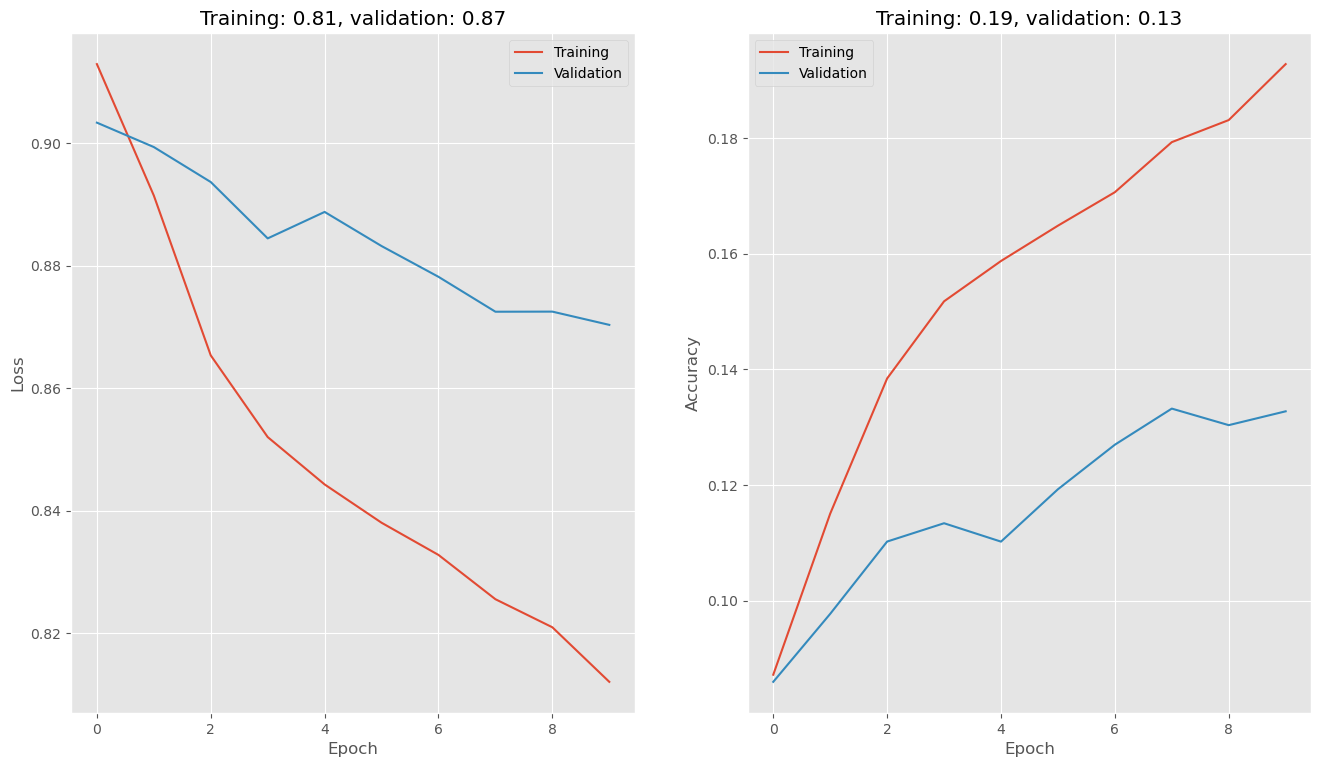

In [112]:
plot_history(history, metric='f1')


## RNN

In [80]:
!pip install keras-tuner

Defaulting to user installation because normal site-packages is not writeable


In [81]:
import keras_tuner as kt

### Keras tunner

Using keras tunner, we are going to find the optimum or at least, the best combination of the model.

In [82]:
# !rm -rf fine_tuning

In [83]:
tf.compat.v1.disable_eager_execution()

In [84]:
tf.keras.backend.clear_session()

In [114]:
class HyperRNN(kt.HyperModel):
    def build(self, hp):
        input_ = tf.keras.layers.Input(shape=(median,))

        embedding_layer = tf.keras.layers.Embedding(
            input_dim=num_words,
            output_dim=EMBEDDING_DIM,
            weights=[embedding_matrix],
            input_length=MAX_SEQUENCE_LENGTH,
            trainable=False,
        )

        emd_layer = embedding_layer(input_)

        lstm_units = hp.Int('lstm_units', min_value=256, max_value=1024, step=256)
        x = tf.keras.layers.LSTM(lstm_units)(emd_layer)
        
        choice = hp.Choice('add_dense_layers', range(0, 2))
        for i in range(choice):
            x = tf.keras.layers.Dense(
                units=hp.Int(f'dense_layer_{i}_units', min_value=8, max_value=256, step=16),
                activation='relu'
            )(x)                
    
        if choice != 0:
            dropout_rate = hp.Int(
                'drop_out_val', min_value=0.2, max_value=0.8, step=0.1)
            x = tf.keras.layers.Dropout(dropout_rate)(x)

        outputs = tf.keras.layers.Dense(OUTPUT_SIZE_UNDER_X+1, activation='sigmoid')(x)
        model = tf.keras.Model(inputs=input_, outputs=outputs)

        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        adam_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=hp_learning_rate)
        model.compile(optimizer=adam_optimizer,
                      loss=f1_loss,
                      metrics=['accuracy', f1])

        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [128, 256, 512]),
            **kwargs,
        )

In [115]:
tuner = kt.Hyperband(HyperRNN(),
                     objective=[
                        kt.Objective('val_f1', 'max'),
                        kt.Objective('loss', 'min')
                    ],
                     max_epochs=100,
                     factor=5,
                     directory='fine_tuning/',
                     project_name='LSTM_with_dropout_v3')

2023-04-28 10:12:39.731304: W tensorflow/c/c_api.cc:300] Operation '{name:'embedding_1/embeddings/Assign' id:531 op device:{requested: '', assigned: ''} def:{{{node embedding_1/embeddings/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](embedding_1/embeddings, embedding_1/embeddings/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [116]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [117]:
tuner.search(data, multihot_X, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 1 Complete [00h 14m 11s]
multi_objective: 0.8069020062685013

Best multi_objective So Far: 0.8069020062685013
Total elapsed time: 00h 14m 11s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
768               |1024              |lstm_units
0                 |0                 |add_dense_layers
0.001             |0.01              |learning_rate
128               |128               |batch_size
4                 |4                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round



2023-04-28 10:26:59.046538: W tensorflow/c/c_api.cc:300] Operation '{name:'embedding/embeddings/Assign' id:17 op device:{requested: '', assigned: ''} def:{{{node embedding/embeddings/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](embedding/embeddings, embedding/embeddings/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Train on 3348 samples, validate on 838 samples


2023-04-28 10:26:59.383700: W tensorflow/c/c_api.cc:300] Operation '{name:'training/Adam/dense/kernel/v/Assign' id:823 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense/kernel/v, training/Adam/dense/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/4


KeyboardInterrupt: 

In [118]:
not_best_model = tuner.get_best_models()[0]
not_best_model.summary()

2023-04-28 10:27:31.992196: W tensorflow/c/c_api.cc:300] Operation '{name:'embedding/embeddings/Assign' id:17 op device:{requested: '', assigned: ''} def:{{{node embedding/embeddings/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](embedding/embeddings, embedding/embeddings/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-04-28 10:27:32.194652: W tensorflow/c/c_api.cc:300] Operation '{name:'total_1/Assign' id:327 op device:{requested: '', assigned: ''} def:{{{node total_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_1, total_1/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 925)]             0         
                                                                 
 embedding (Embedding)       (None, 925, 300)          12000000  
                                                                 
 lstm (LSTM)                 (None, 1024)              5427200   
                                                                 
 dense (Dense)               (None, 55)                56375     
                                                                 
Total params: 17,483,575
Trainable params: 5,483,575
Non-trainable params: 12,000,000
_________________________________________________________________


In [119]:
best_hps = tuner.get_best_hyperparameters()[0]

In [120]:
best_hps.space


[Int(name: 'lstm_units', min_value: 256, max_value: 1024, step: 256, sampling: linear, default: 256),
 Choice(name: 'add_dense_layers', values: [0, 1], ordered: True, default: 0),
 Choice(name: 'learning_rate', values: [0.01, 0.001, 0.0001], ordered: True, default: 0.01),
 Choice(name: 'batch_size', values: [128, 256, 512], ordered: True, default: 128)]

In [96]:
model = tuner.hypermodel.build(best_hps)


2023-04-28 09:47:31.400634: W tensorflow/c/c_api.cc:300] Operation '{name:'embedding_1/embeddings/Assign' id:531 op device:{requested: '', assigned: ''} def:{{{node embedding_1/embeddings/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](embedding_1/embeddings, embedding_1/embeddings/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [97]:
history_best_model = model.fit(data, multihot_X, validation_split=0.2 ,epochs=10)

Train on 3348 samples, validate on 838 samples
Epoch 1/10


2023-04-28 09:47:36.075947: W tensorflow/c/c_api.cc:300] Operation '{name:'training/Adam/dense_3/bias/v/Assign' id:1388 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_3/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_3/bias/v, training/Adam/dense_3/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


3348/3348 [==============================] - ETA: 0s - loss: 0.9104 - accuracy: 0.0863 - f1: 0.0880

/home/tena/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-04-28 09:48:29.702813: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_1/mul' id:999 op device:{requested: '', assigned: ''} def:{{{node loss_1/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_1/mul/x, loss_1/dense_3_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


3348/3348 [==============================] - 59s 18ms/sample - loss: 0.9104 - accuracy: 0.0863 - f1: 0.0880 - val_loss: 0.8991 - val_accuracy: 0.4129 - val_f1: 0.1005
Epoch 2/10
3348/3348 [==============================] - 59s 18ms/sample - loss: 0.8909 - accuracy: 0.0263 - f1: 0.1095 - val_loss: 0.9008 - val_accuracy: 0.0024 - val_f1: 0.0993
Epoch 3/10
3348/3348 [==============================] - 59s 17ms/sample - loss: 0.8771 - accuracy: 0.0227 - f1: 0.1233 - val_loss: 0.8984 - val_accuracy: 0.0179 - val_f1: 0.1015
Epoch 4/10
3348/3348 [==============================] - 59s 18ms/sample - loss: 0.8744 - accuracy: 0.0122 - f1: 0.1257 - val_loss: 0.8982 - val_accuracy: 0.0048 - val_f1: 0.1010
Epoch 5/10
3348/3348 [==============================] - 57s 17ms/sample - loss: 0.8723 - accuracy: 0.0544 - f1: 0.1282 - val_loss: 0.8967 - val_accuracy: 0.1551 - val_f1: 0.1011
Epoch 6/10
3348/3348 [==============================] - 58s 17ms/sample - loss: 0.8707 - accuracy: 0.1314 - f1: 0.1296 - 

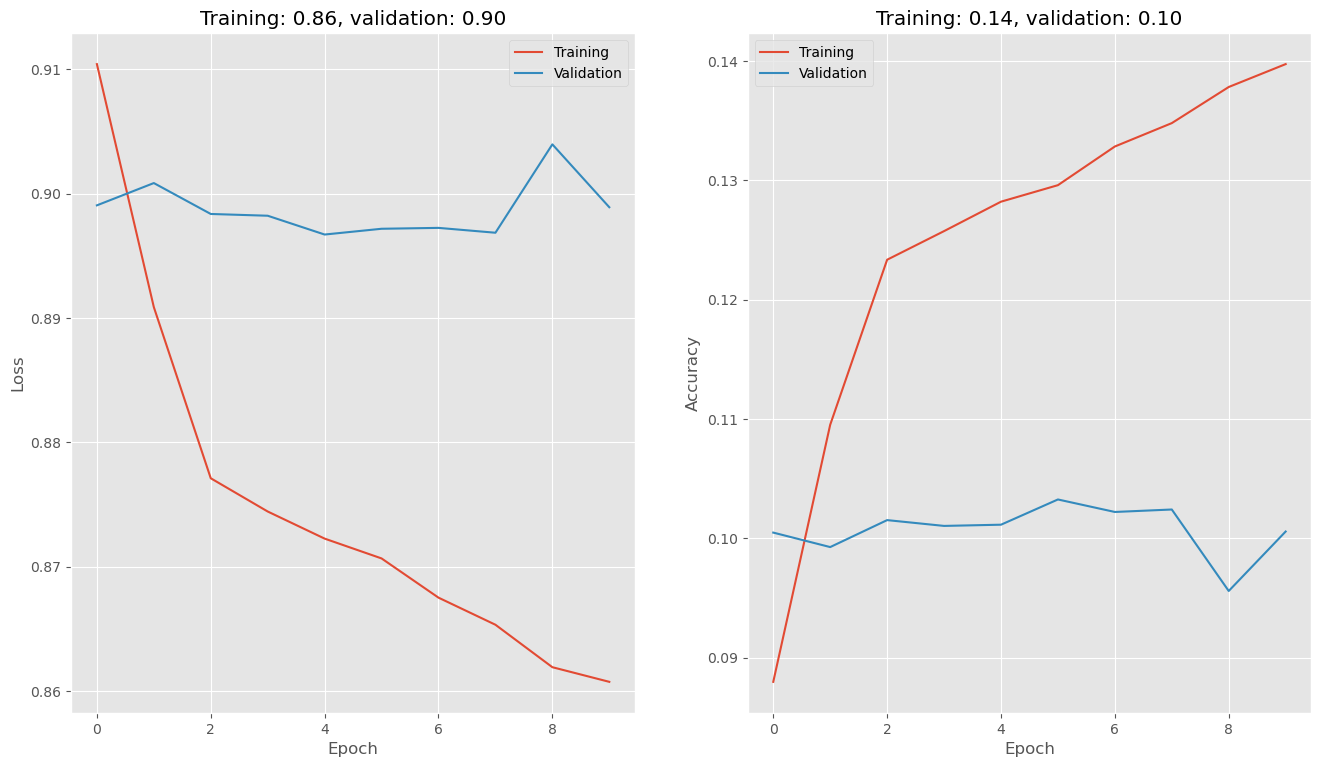

In [98]:
plot_history(history_best_model, metric='f1')


In [ ]:
!zip -r fine_tuning.zip /content/fine_tuning

In [ ]:
from google.colab import files
files.download("fine_tuning.zip")

### With LSTM

In [ ]:
from keras import layers

rnn_lstm = tf.keras.Sequential()

rnn_lstm.add(embedding_layer)

rnn_lstm.add(layers.LSTM(150))
rnn_lstm.add(layers.Dropout(0.5))
rnn_lstm.add(layers.Dense(OUTPUT_SIZE_UNDER_X+1, activation='sigmoid'))

rnn_lstm.summary()

In [ ]:
# Compile the model with F1 score metric
rnn_lstm.compile(
    optimizer='adam', #tf.keras.optimizers.RMSprop(learning_rate=0.01),
    loss=f1_loss,
    metrics=['accuracy', f1]
)

In [ ]:
history_rnn_lstm = rnn_lstm.fit(data, multihot_X, validation_split=0.2 ,epochs=10)

In [ ]:
plot_history(history_rnn_lstm, metric='f1')

### With GRU

In [ ]:
from keras import layers

rnn = tf.keras.Sequential()

rnn.add(embedding_layer)

rnn.add(layers.GRU(128))
rnn.add(layers.Dropout(0.5))
rnn.add(layers.Dense(OUTPUT_SIZE_UNDER_X+1, activation='sigmoid'))

rnn.summary()

In [ ]:
# Compile the model with F1 score metric
rnn.compile(
    optimizer='adam', #tf.keras.optimizers.RMSprop(learning_rate=0.01),
    loss=f1_loss,
    metrics=['accuracy', f1]
)

In [ ]:
history_rnn = rnn.fit(data, multihot_X, validation_split=0.2 ,epochs=10)

In [ ]:
plot_history(history_rnn, metric='f1')

# Example (Some tests to dabstracts)

Conocimiento cogido de https://www.nltk.org/book/

In [ ]:
example = X.values[0]
example

In [ ]:
tokens = nltk.word_tokenize(example.lower())
tokens[:5]  # Los puntos, comas y demás también se separan

### Frecuencia

En las siguientes celdas se mostrará información sobre la frecuencia de las palabras. Es decir, el número de veces que se repite una palabra.

In [ ]:
fdist1 = nltk.punkt.FreqDist(tokens)

In [ ]:
fdist1.most_common(10)

In [ ]:
type(fdist1)

In [ ]:
fdist1.plot(title="Frecuencia de example")

Como se puede observar, en el abstract de example, se tienen muchos valores que solo aparecen una vez, también son llamados `hapaxes`. Esto no puede interesar, porque si existen palabras con pocas repeticiones en todos los abstracts, entonces las podemos eliminar.

In [ ]:
print(f'Nº de palabras únicas: {len(fdist1.hapaxes())}, ejemplos: {fdist1.hapaxes()[:5]}')

Bigramas. Son secuencias de palabras. Por ejemplo, `vino rojo`. Esto es importante, ya que `vino marrón` suena muy mal. Por supuesto, al coger bigramas, estamos cogiendo conjuntos de dos datos. Lo que signigica que habrá muchos que no tengan sentido.

Lo bueno, `nltk` tiene un modulo llamado `collocations` que genera **bigramas** más "importantes" o que, se pueden "encontrar" en la realidad. Estos valores se sacan con una tabla de **contingencia**.

https://tedboy.github.io/nlps/generated/generated/nltk.BigramAssocMeasures.html

In [ ]:
list(nltk.bigrams(tokens))

In [ ]:
b_finder = nltk.collocations.BigramCollocationFinder.from_words(tokens)

In [ ]:
bigram_measures = nltk.collocations.BigramAssocMeasures()

In [ ]:
b_finder.nbest(bigram_measures.pmi, 10)

También se pueden contar el número de veces que aparece el tamaño de las palabras.

In [ ]:
fdLen = nltk.punkt.FreqDist(len(w) for w in tokens)

In [ ]:
max = fdLen.max()
print(f'El tamaño de las palabras más repetidas es {max}:\n\t- Frecuencia : {fdLen[max]}\n\t- Frecuencia (%): {fdLen.freq(max)}')

In [ ]:
print(f'Número total de samples: {fdLen.N()}')

### Best way to do everything earlier

Converting the string into a nltk.Text(), using the `stopwords` dataset, we can see that the collocations are way better than earlier.

In [ ]:
text = nltk.Text(tokens)
text[:5]

In [ ]:
text.collocations()

### Tagging

Lo que mola de `nltk`, es que, una vez tienes las palabras, puedes clasificar las palabras. Usa el paquete: `averaged_perceptron_tagger`

- `cc` coordinating conjunction
- `rb` adverbs
- `in` preposition
- `nn` noun
- `jj` adjective
- `vbp` verb

#### Pos_tagger

In [ ]:
tags = nltk.pos_tag(tokens)
tags[:5]

In [ ]:
len(tags)

In [ ]:
# get rid of prepositions
len([word for word, tag in tags if tag != 'IN'])